# IMDB Movie Sentiment Analysis using RNN and LSTM RNN

## Introduction

Sentiment analysis is a key task in Natural Language Processing (NLP) that aims to determine whether a given piece of text expresses a 
positive, negative, or neutral sentiment. One of the most widely used benchmark datasets for sentiment classification is the `IMDB Movie Review Dataset`, which contains 50,000 highly polarized movie reviews (25,000 for training and 25,000 for testing), labeled as positive or negative.

**The goal of this project is to build a deep learning model that can automatically classify the sentiment of a movie review as either positive or negative.**

## Why Recurrent Neural Networks (RNNs)?

Unlike traditional machine learning models, `Recurrent Neural Networks (RNNs)` are designed to handle sequential data, making them highly effective for text analysis. In natural language, the meaning of a word often depends on the words that precede or follow it. RNNs capture these dependencies and context by maintaining a hidden state that gets updated as they process each token in the sequence.

For example:

- "The movie was great." → Positive sentiment

- "The movie was not great." → Negative sentiment

Here, the presence of "not" changes the meaning of "great." RNNs are capable of learning such contextual relationships, unlike simpler models like bag-of-words or logistic regression.

## Problem Statement

Given a dataset of IMDB movie reviews labeled as positive or negative, build a Recurrent Neural Network-based sentiment analysis model that can accurately predict the sentiment of a review.

In [1]:
# Importing required libraries

import re
import nltk
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('dataset/IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
data.shape

(50000, 2)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


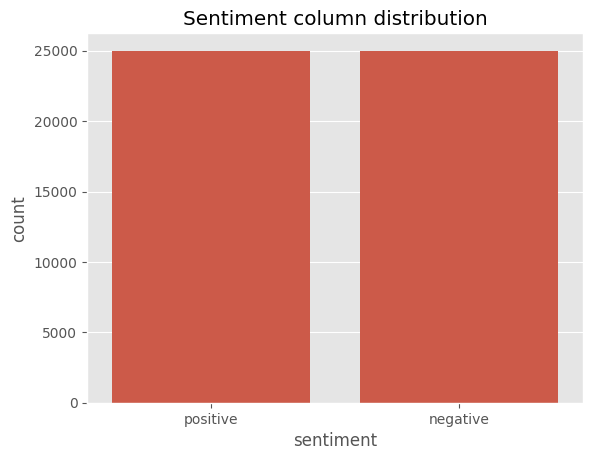

In [5]:
# Checking the distribution of the Sentiment column

plt.style.use("ggplot")
sns.countplot(data = data, x = data["sentiment"])
plt.title('Sentiment column distribution')
plt.show()

**There is no class imbalance both class has an equal number of data.**

In [6]:
# Checking one review entry
data["review"][12]

'So im not a big fan of Boll\'s work but then again not many are. I enjoyed his movie Postal (maybe im the only one). Boll apparently bought the rights to use Far Cry long ago even before the game itself was even finsished. <br /><br />People who have enjoyed killing mercs and infiltrating secret research labs located on a tropical island should be warned, that this is not Far Cry... This is something Mr Boll have schemed together along with his legion of schmucks.. Feeling loneley on the set Mr Boll invites three of his countrymen to play with. These players go by the names of Til Schweiger, Udo Kier and Ralf Moeller.<br /><br />Three names that actually have made them selfs pretty big in the movie biz. So the tale goes like this, Jack Carver played by Til Schweiger (yes Carver is German all hail the bratwurst eating dudes!!) However I find that Tils acting in this movie is pretty badass.. People have complained about how he\'s not really staying true to the whole Carver agenda but we

## Data Preprocessing

In [7]:
from nltk.corpus import stopwords

stopwords_list = set(stopwords.words('english'))

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    """
    Uses regex to find anything inside <...> and remove it
    """
    return TAG_RE.sub('', text)

In [8]:
class PreprocessData():
    """
    This class is a pipeline for cleaning text. It removes html tags,
    punctuations, numbers, single characters, multiple spaces, and stopwords.
    """
    def __init__(self):
        pass
    
    def preprocess_text(self, sentence):
        sentence = sentence.lower()

        # Remove html tags
        sentence = remove_tags(sentence)

        # Remove Punctuations & Numbers
        sentence = re.sub('[^a-zA-Z]', ' ', sentence)

        # Remove Single Characters
        sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

        # Remove Multiple Spaces
        sentence = re.sub(r'\s+', ' ', sentence)
        
        # Remove Stopwords
        pattern = re.compile(r'\b(' + r'|'.join(stopwords_list) + r')\b\s*')
        sentence = pattern.sub('', sentence)
        
        return sentence

In [9]:
# Preprocessing a sample sentence

preprocess = PreprocessData()
preprocess.preprocess_text("There are some things worth mentioning that would imply that Boll did a good work on some areas of the film such as some nice boat and fighting scenes.")

'things worth mentioning would imply boll good work areas film nice boat fighting scenes '

**Only important words like nouns, verbs, adjectives, and adverbs are kept. Stopwords like "is", "the", "and", etc. are removed.**

In [10]:
# Building the preprocessed dataset

X = []
sentences = list(data['review'])

for sentence in sentences:
    X.append(preprocess.preprocess_text(sentence))

In [11]:
# Target label mapping

Y = data['sentiment']
sentiment_map = {'negative' : 0, 'positive': 1}

Y = np.array(Y.map(sentiment_map))
Y[:10]

array([1, 1, 1, 0, 1, 1, 1, 0, 0, 1])

**Now X and Y form the input (features) and output (labels) for training the RNN sentiment classifier.**

## Train-Test split

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, test_size = 0.2, random_state = 42)

## Word Embeddings

Raw text cannot be directly fed into a neural network, so words need to be converted into numerical representations. A simple approach is one-hot encoding, but it results in sparse vectors and does not capture semantic relationships between words.

Instead, we use **word embeddings**, which are dense, low-dimensional vector representations of words. These embeddings capture semantic meaning — words with similar meanings end up having similar vector representations. For example:

- "good", "excellent", and "amazing" will be close in the embedding space.

- "bad", "terrible", and "awful" will form another cluster.

In [13]:
# Using tokenizer to build a vocabulary dictionary for mapping words → unique integers

from tensorflow.keras.preprocessing.text import Tokenizer

vocab_size = 10000
tokenizer = Tokenizer(num_words = vocab_size, oov_token = "<OOV>")

**fit_on_texts()** scans through all training sentences in the given data

It builds a vocabulary dictionary where:

- The most frequent word gets the smallest integer (usually 1).

- Each subsequent word gets a unique integer ID.

In [14]:
tokenizer.fit_on_texts(X_train)

In [15]:
# Converting each training sentence into a sequence of integers using the word index built above.

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [16]:
# Unique tokens from the training text

vocabulary_length = len(tokenizer.word_index) + 1 # We add +1 because index 0 is reserved for padding tokens
vocabulary_length

92395

- After tokenization, each review is converted into a sequence of integers, the length of each review could be different.

- Neural networks need inputs of the same size.

- **pad_sequences** standardizes sequence length by either:
    - `Padding`(adding zeros at the beginning or end of shorter sequences) or
    
    - `Truncating` (cutting longer sequences down to maxlen).

In [17]:
# Padding

from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 250

X_train = pad_sequences(X_train, maxlen = maxlen)
X_test = pad_sequences(X_test, maxlen = maxlen)

In [18]:
X_train

array([[   0,    0,    0, ...,   97,  233, 3672],
       [   0,    0,    0, ...,   23, 1546,   28],
       [   0,    0,    0, ...,  198,  570,   10],
       ...,
       [   0,    0,    0, ...,  980, 1472,  461],
       [   0,    0,    0, ...,   28, 6818,    1],
       [   0,    0,    0, ...,  346,   14, 1809]], dtype=int32)

## Training Recurrent Neural Network (RNN)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

model = Sequential()

In [20]:
# Embedding layer: Converts word indices (integers) into dense vector embeddings
model.add(Embedding(10000, 128, input_shape=(maxlen,)))

# SimpleRNN Layer: Processes the sequence of embeddings one step at a time
model.add(SimpleRNN(128, activation = 'relu'))

# Dense Layer: Final classification layer
model.add(Dense(1, activation = 'sigmoid'))

/opt/anaconda3/envs/venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 250, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,313,025 (5.01 MB)

 Trainable params: 1,313,025 (5.01 MB)

 Non-trainable params: 0 (0.00 B)

**EarlyStopping** automatically stops training your model early when it sees that your validation performance isn’t improving anymore, helps prevent overfitting and wasted training time.

In [22]:
# Creating an instance of EarlyStopping Callback
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor = 'val_loss',          # what metric to watch → here it's validation loss
    patience = 5,                  # how many epochs to wait before stopping if no improvement
    restore_best_weights = True    # after stopping, roll back to the best model weights
)

early_stopping

In [23]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [24]:
# Training the model

history = model.fit(X_train, Y_train, epochs = 20, batch_size = 32,
          validation_split = 0.2,
          callbacks = [early_stopping]
)

Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.6529 - loss: 1.1915 - val_accuracy: 0.6440 - val_loss: 0.6269
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - accuracy: 0.7887 - loss: 0.4556 - val_accuracy: 0.8583 - val_loss: 0.3336
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - accuracy: 0.8909 - loss: 0.2754 - val_accuracy: 0.8618 - val_loss: 0.3314
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 43s 43ms/step - accuracy: 0.9214 - loss: 0.2009 - val_accuracy: 0.8620 - val_loss: 0.3748
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - accuracy: 0.9423 - loss: 0.1553 - val_accuracy: 0.8466 - val_loss: 0.4557
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 43s 43ms/step - accuracy: 0.9544 - loss: 0.1218 - val_accuracy: 0.8583 - val_loss: 0.4393
Epoch 7/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - accuracy: 0.9189 - loss: 0.1957 - val_accuracy: 0.7418 - val_loss: 0.6578
Epoch 8/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 43s 43ms/step - accuracy: 0.9570 -

In [25]:
result = model.evaluate(X_test, Y_test, verbose = 1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8658 - loss: 0.3234


In [26]:
print("Test Accuracy:", result[1])
print("Test Loss:", result[0])

Test Accuracy: 0.8658000230789185
Test Loss: 0.3234105706214905


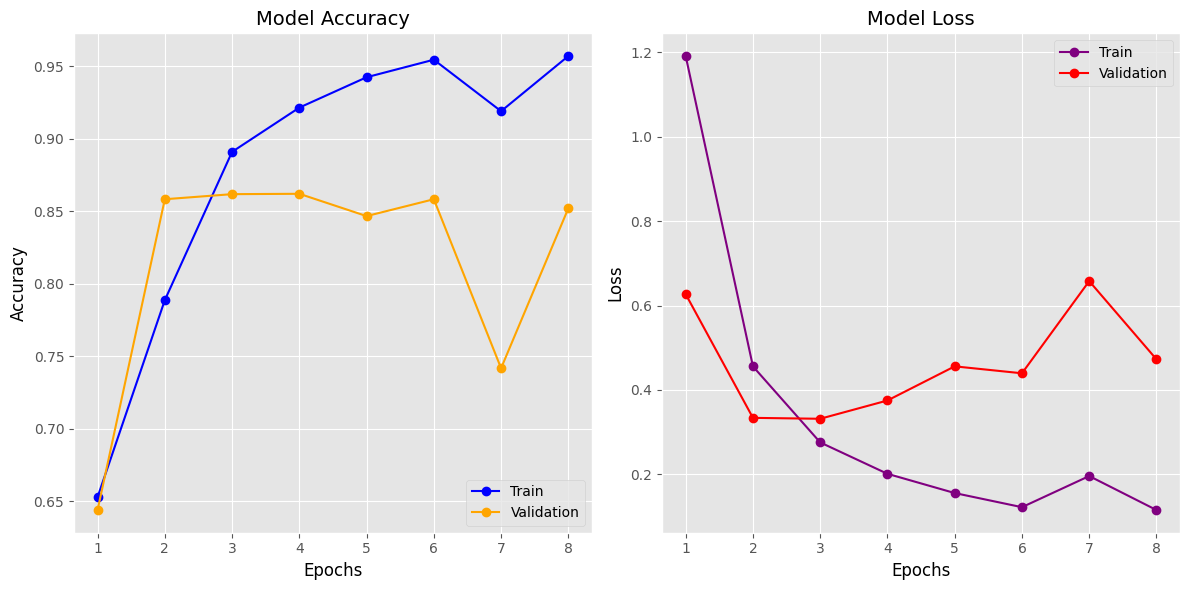

In [27]:
# Number of epochs 
epochs = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(12, 6))

# Accuracy Plot 
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["accuracy"], color = 'blue', marker = 'o')
plt.plot(epochs, history.history["val_accuracy"], color = 'orange', marker = 'o')
plt.title("Model Accuracy", fontsize = 14)
plt.xlabel("Epochs", color = 'black')
plt.ylabel("Accuracy", color = 'black')
plt.legend(['Train', 'Validation'], loc = "lower right")

# Loss Plot 
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["loss"], color = 'purple', marker = 'o')
plt.plot(epochs, history.history["val_loss"], color = 'red', marker = 'o')
plt.title("Model Loss", fontsize = 14)
plt.xlabel("Epochs", color = 'black')
plt.ylabel("Loss", color = 'black')
plt.legend(['Train', 'Validation'], loc = "upper right")

plt.tight_layout()
plt.show()


## Why Long Short-Term Memory (LSTM) Networks?

`Long Short-Term Memory (LSTM)` networks are an advanced type of Recurrent Neural Network (RNN) designed to overcome the vanishing and exploding gradient problems that limit standard RNNs. While RNNs are good at handling sequential data, they struggle to capture long-term dependencies in sequences. LSTMs solve this by introducing a more sophisticated architecture that includes memory cells and gating mechanisms (input, forget, and output gates).

This allows LSTMs to selectively remember or forget information over longer time spans, making them particularly effective for natural language tasks where context may be spread across many words.

For example:

- "The movie that I watched last week was amazing." → Positive sentiment

- "The movie that I watched last week was not amazing." → Negative sentiment

Here, the key word "not" occurs far from "amazing", and a simple RNN might fail to connect the two. LSTMs can maintain the necessary context across the entire sequence, ensuring accurate interpretation of meaning.

Compared to traditional RNNs, LSTMs are better suited for:

- Sentiment analysis

- Machine translation

- Speech recognition

- Any task involving long-term contextual dependencies

## Training Long-Short Term Memory RNN (LSTM RNN)

In [30]:
from tensorflow.keras.layers import LSTM, Input

In [32]:
# Training using LSTM
lstm = Sequential()

# Explicit input layer
lstm.add(Input(shape = (maxlen,)))  

# Embedding layer: Converts word indices (integers) into dense vector embeddings
lstm.add(Embedding(10000, 128))

# LSTM layer: Learns sequential dependencies in the embedded word vectors
lstm.add(LSTM(128))

# Output layer: A dense layer with sigmoid activation for binary classification
lstm.add(Dense(1,activation = 'sigmoid'))

In [35]:
lstm.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 250, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,411,713 (5.39 MB)

 Trainable params: 1,411,713 (5.39 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
lstm.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [36]:
# Training the model

history = lstm.fit(X_train, Y_train, epochs = 20, batch_size = 32,
          validation_split = 0.2,
          callbacks = [early_stopping]
)

Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 139s 138ms/step - accuracy: 0.8295 - loss: 0.3821 - val_accuracy: 0.8736 - val_loss: 0.3091
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 138s 138ms/step - accuracy: 0.9102 - loss: 0.2317 - val_accuracy: 0.8800 - val_loss: 0.2946
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 131s 131ms/step - accuracy: 0.9410 - loss: 0.1634 - val_accuracy: 0.8644 - val_loss: 0.3469
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 129s 129ms/step - accuracy: 0.9589 - loss: 0.1178 - val_accuracy: 0.8639 - val_loss: 0.4494
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 129s 129ms/step - accuracy: 0.9644 - loss: 0.1044 - val_accuracy: 0.8641 - val_loss: 0.3907
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 130s 130ms/step - accuracy: 0.9802 - loss: 0.0625 - val_accuracy: 0.8692 - val_loss: 0.4990
Epoch 7/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 123s 123ms/step - accuracy: 0.9880 - loss: 0.0391 - val_accuracy: 0.8650 - val_loss: 0.5660


In [38]:
result = lstm.evaluate(X_test, Y_test, verbose = 1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8852 - loss: 0.2820


In [39]:
print("Test Accuracy:", result[1])
print("Test Loss:", result[0])

Test Accuracy: 0.885200023651123
Test Loss: 0.2820243537425995


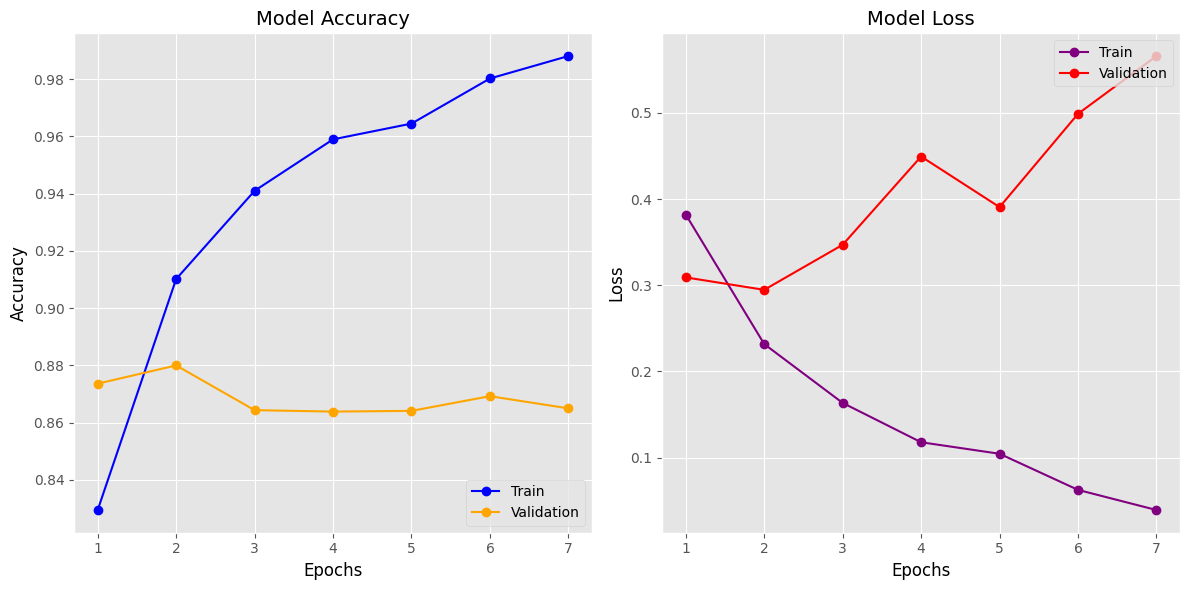

In [40]:
# Number of epochs 
epochs = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(12, 6))

# Accuracy Plot 
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["accuracy"], color = 'blue', marker = 'o')
plt.plot(epochs, history.history["val_accuracy"], color = 'orange', marker = 'o')
plt.title("Model Accuracy", fontsize = 14)
plt.xlabel("Epochs", color = 'black')
plt.ylabel("Accuracy", color = 'black')
plt.legend(['Train', 'Validation'], loc = "lower right")

# Loss Plot 
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["loss"], color = 'purple', marker = 'o')
plt.plot(epochs, history.history["val_loss"], color = 'red', marker = 'o')
plt.title("Model Loss", fontsize = 14)
plt.xlabel("Epochs", color = 'black')
plt.ylabel("Loss", color = 'black')
plt.legend(['Train', 'Validation'], loc = "upper right")

plt.tight_layout()
plt.show()


**Using LSTM we achieved an accuracy of 88.5% on the test set, which is a significant improvement over the standard RNN model.**

In [ ]:
# Run this command to save this model locally for End to End Prediction

lstm.save("lstm_sentiment_classifier.h5")